# Project Context - Data Science Challenge for an Interview

This project is a data science challenge I completed for a small, boutique consulting firm. I liked this project and wanted to share because it requried me to learn something new. I had to identify the correct approach to solve this problem, find a library that implements the appropriate approach, and make slight adjustments to my model evaluation (standard sci-kit learn libraries would not support the model evaluation methods).

This problem required me to learn about Positive-Unlabeled learning (PU Learning). Instead of the traditional Case-Control or 1-0 format, this data takes on the form of Positive and Unlabeled, as in, we don't know if the unlabeled observations would be positive or negative because we haven't applied a treatment. We only know that the positives are positives.

As a disclaimer upfront, this interview process did not have an NDA. I have completed other interview processes that did have an NDA and you will not find them in my gitHub account, or anywhere else.

# The Text of the assignment


### Challenge Overview:

A client has approached us with a dataset of their clients, including various attributes like interactions with services, demographic details, and financial information. Each client is labeled either as "Advisory" (those who are using advisory services) or
 "Unknown." The "Unknown" label represents clients for whom it is unclear whether they don't need advisory services or might be great candidates for it but haven't opted for the service yet.

In addition to the original dataset, the client has provided a secondary dataset of client transactions that includes dates, amounts, and types of transactions. They suspect there may be a relationship between a client’s most recent transaction, the most frequent
 type of transaction, the total amount of transactions, and the likelihood of needing advisory services.

### Your Task:

Your challenge is to build a model that predicts which of the "Unknown" labeled clients are potential candidates for advisory services. This involves analyzing both datasets to identify patterns or characteristics—including financial behaviors indicated by
 the transaction data—that distinguish potential candidates for advisory services.




# My work begins here:

## Pre-analysis reading and understanding

I started by reading the prompt a few times and taking notes on the key pieces of information. There are two datasets and the target variable contains *Positives* and *Unknowns.* Typically, there are *Positives,* *Negatives,* and *Unknowns.* This is new for me, so I went to every Data Scientist's favorite tool - Google.


#### Elkan and Noto
My searches lead me to the field of PU Learning. While the name leaves something to be desired, I found a great paper by [Elkan and Noto](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://cseweb.ucsd.edu/~elkan/posonly.pdf&ved=2ahUKEwi2pYizvNmFAxXPkIkEHa67B8UQFnoECA8QAQ&usg=AOvVaw1o-E1rzGkbTquUxZtb69md) on the subject. The paper is great and the proof is easy to follow (I only followed it loosely, there are enough citations on Google that I trust it's validity). The paper makes an adjustment to our traditional machine learning process that enables PU Learning under the assumption that the positives are SCAR (Selected Completely At Random). This assumption may not hold 100%, but I think the process of getting clients is sufficiently random that this should hold

#### The Naive Approach
The Naive approach assumes that "Unknown" and "Negative" are the same. I don't like this at all because that assumption doesn't hold. The name seems accurate here and I find this approach unpalatable.

#### imPULSE

I found a towards data science article that proposes another method that is relatively complex, but performs well on imbalanced data. There is no mathematical proof and I didn't see any peer reviews on this (they may exist, I didn't spend a ton of time searching for them). This makes me nervous to implement the method. I tend to gravitate towards research that is published and peer reviewed because I trust the rigorous review process. That process is capable of missing errors, but it does so infrequently.

#### Selected Method: Elkan and Noto
Peer reviewed and a simple but elegant proof? Sign me up. The assumption might not hold 100%, but I'm more comfortable with that as opposed to the other two methods.

## My Plan:

Every good project begins with a plan to guide it.

1) Inspect the Advisory (primary) dataset
2) Clean the Advisory dataset, noting any questionable decisions and assumptions
    - Be ready to share those assumptions and cleaning steps with clients to build trust and gather their feedback. Transparency helps data scientists become trusted advisors by eliminating the smoke and mirrors.
3) Visualize the data and generate some hunches about features. This may help with feature selection (if necessary)
4) Inspect the Transaction data
5) Build the features
    - I considered engineering additional features. I love feature engineering, but this is a rush job. I decided to avoid feature engineering in the interest of time  
6) Join the data prior to analysis, confirm there are no NAs or other flaws
7) Fit a model
8) Parameter tune via CV-folds
    - For this, I will be deviding the data into 10-folds. Each fold will have 2 'Advisory' observations that have been artificially flipped to 'Unknown'. The model's performance will be it's ability to correctly label those values as Advisory.
9) Take the best model, generate labels.
10) Prep for Clients

In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from pulearn import ElkanotoPuClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


### import my functions
from cleaningAndFeatures import *

seedA = 10

## Load Data

In [59]:
adv = pd.read_csv("advisory.csv")
trans = pd.read_csv("client_transactions.csv")

## 1 -  Inspect the Advisory data

As expected, there is an ID and Label for each observation. Notably, there are 20 NAs for Age and Income - we will need to inspect these to handle them correctly. Additionally, we will want to inspect the factor levels for anything erroneous. 

In [60]:
adv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  200 non-null    int64  
 1   Label               200 non-null    object 
 2   Age                 180 non-null    float64
 3   Income              180 non-null    float64
 4   Job Type            200 non-null    object 
 5   Tax Classification  200 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 9.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  200 non-null    int64  
 1   Label               200 non-null    object 
 2   Age                 180 non-null    float64
 3   Income              180 non-null    float64
 4   Job Type            200 non-null    obj

In [61]:
## the shapes match, therefore we have complete cases for all advisory data. Excellent.
print(adv[adv['Label'] == 'Advisory'].shape)
print(adv[adv['Label'] == 'Advisory'].dropna(axis = 0, how = 'any').shape)

(20, 6)
(20, 6)
(20, 6)
(20, 6)


### Handling NAs

The 20 NAs are present for Age and Income. This could be used as a justification to drop these observations from the dataset; however, the case stated the clients *"suspect there may be a relationship between a client’s most recent transaction, the most frequent type of transaction, the total amount of transactions, and the likelihood of needing advisory services."* None of those features have anything to do with Age or Income, so dropping them could eliminate a strong potential candidate. 

I'm going to add the mean by factor-level when cleaning this data. There should be an average value of age and income for each combination of Job Type and Tax Classification. This should be sufficient in this case. I'm going to write a quick function that I will call during the main cleaning function at the end.

In [62]:
adv[adv['Age'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 15 to 186
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20 non-null     int64  
 1   Label               20 non-null     object 
 2   Age                 0 non-null      float64
 3   Income              0 non-null      float64
 4   Job Type            20 non-null     object 
 5   Tax Classification  20 non-null     object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 15 to 186
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20 non-null     int64  
 1   Label               20 non-null     object 
 2   Age                 0 non-null      float64
 3   Income              0 non-null      float64
 4   Job Type            20 non-null     obj

### Inspect the Factor-level data

Next, we want to identify any erroneous factor-level data in Job Type and Tax Classification.

#### Job Type
It seems clear that 'Vr' is intended to be 'VP' - I am going to make this change. Chief Officier appears to be a misspelling, but it is uniform and won't impact the analysis. I'm going to leave this alone.

#### Tax Classification
There are a number of examples where the final character of the string was changed to 'd' instead of the correct character. I am going to change these in the cleaning script.

In [63]:
adv['Job Type'].unique()

array(['Chief Officier', 'VP', 'Owner', 'Vr'], dtype=object)

In [64]:
adv['Tax Classification'].unique()

array(['Low', 'High', 'Medium', 'Mediud', 'Lod', 'Higd'], dtype=object)

### Analysing the Continuous Variables

To analyze these variables, we want to look at the descriptive statistics as well as a plot of the distribution of values. A histogram or KDE would work here, but I prefer a KDE because it gives me a better idea of the shape. The function below will create the KDE and a few descriptive stats.

There are no erroneous values in the continuous variables. There are some values that have a small decimal value, but that won't be material for modeling a continuous variable. Still, we will round these during cleaning.

In [65]:
def descriptiveKDE(df, variable):
    vals = df[variable][df[variable].notnull()].values
    posVals = df[variable][df['Label'] == 'Advisory']
    unlabVals = df[variable][(df['Label'] != 'Advisory') & df[variable].notnull()]
    fig = sns.kdeplot(vals, color = 'black', label = 'All Values')
    fig = sns.kdeplot(posVals, color = 'blue', alpha = .7, label = 'Positives')
    fig = sns.kdeplot(unlabVals, color = 'red', alpha = .7, label = 'Unlabeled')
    
    med = round(np.median(vals))
    mean = round(np.mean(vals))
    min = round(np.min(vals))
    max = round(np.max(vals))
    text = "Min: {} | Max: {} | Median: {} | Mean: {}".format(min,max,med,mean)
    
    plt.axvline(x = mean, color = 'green', label = 'Mean', linestyle = '--')
    plt.axvline(x = mean, color = 'purple', label = 'Median', linestyle = '--')
    
    return fig, text

#### Income Density and Descriptive Stats

The mean and median are quite close, which explains why the mean is not visible on the plot. They are also near the maximum density on the plot, which suggests either would approximate an MLE in this case.

Notably, the Positive values have a narrower distribution compared to the Unlabeled values. The maximum Positive value is less than 1M, where as there are many Unlabeled observations greater than 1M. As such, it appears that this variable may help identify some negative values within the Unlabeled group. This is something we will want to test when modeling.

Min: 203000 | Max: 3920000 | Median: 529000 | Mean: 613339
Min: 203000 | Max: 3920000 | Median: 529000 | Mean: 613339


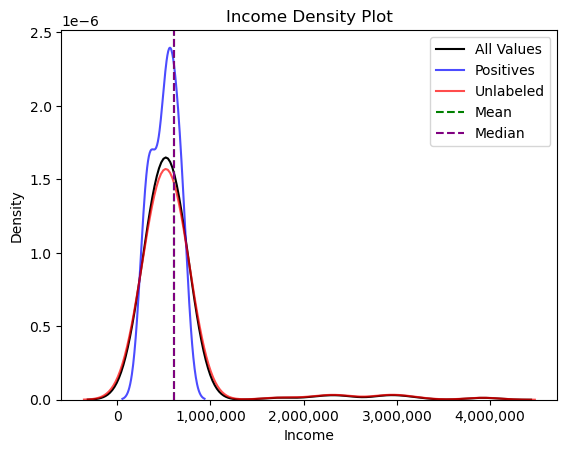

In [66]:
xticks = [0, 1000000, 2000000, 3000000, 4000000]
xlabels = ['0', '1,000,000', '2,000,000', '3,000,000', '4,000,000']
fig, text = descriptiveKDE(adv, 'Income')
plt.title('Income Density Plot')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(xticks, xlabels)
plt.legend()
print(text)
plt.show()

As shown in Income, the mean and median are nearly the same. This distribution appears to be bimodal. There are maximums near 28 and 50. Unlike Income, this variable does not show any visible potential to separate the unlabeled data; however, there may be an effect that isn't visible. This will still be considered in the model.

Min: 18 | Max: 68 | Median: 44 | Mean: 43
Min: 18 | Max: 68 | Median: 44 | Mean: 43


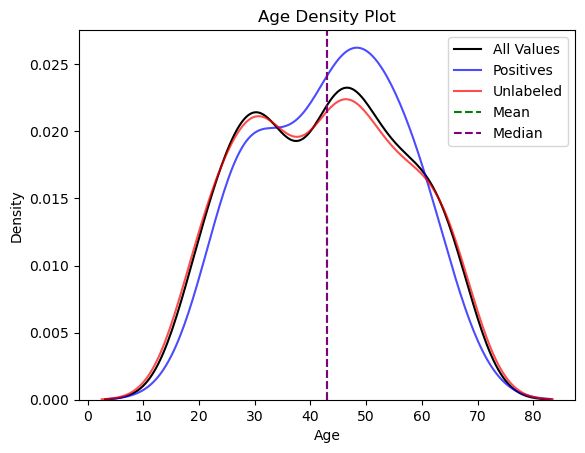

In [67]:
fig, text = descriptiveKDE(adv, 'Age')
plt.title('Age Density Plot')
plt.ticklabel_format(style='plain', axis='x')
plt.legend()
print(text)
plt.show()

In [68]:
round(adv['Income'].loc[adv['Income'].notnull()],0)

0      512000.0
1      295000.0
2      445000.0
3      565000.0
4      327000.0
         ...   
195    675000.0
196    373000.0
197    563000.0
198    364000.0
199    215000.0
Name: Income, Length: 180, dtype: float64

## 2 - Clean the Data

This happens explicitly below, but it has also occurred in the steps above via the functions I wrote

In [69]:
adv.head()

,ID,Label,Age,Income,Job Type,Tax Classification
0,1,Unknown,39.0,512000.0,Chief Officier,Low
1,2,Advisory,24.0,295000.0,VP,High
2,3,Unknown,36.0,445000.0,Chief Officier,High
3,4,Unknown,50.0,565000.0,Chief Officier,Medium
4,5,Unknown,19.0,327000.0,Owner,Low


In [70]:
advClean = cleanAdv(adv)

## 3) Visualize a few interactions

We've already done some EDA on Age and Income, forming the hypotheses that Income may help identify potential candidates and that Age appears unlikely to be helpful. Now we will explore Tax Classification and Job Type via mosaic plots. This will treat Label and either Tax Classification or Job Type as a pair of factors, forming a two-way table and applying some visualization to it. This should provide some insight into a potential association between Label and the two factors.

We could go one-step further and perform a chi-sq test for independence, but that is unnecessary based on the text in the challenge. In a client setting, I may choose to do this if I felt the client would be interested in the extra knowledge or seeing the analysis.

#### Tax Classification

The unknown labels appear to be divided into perfect thirds, whereas the Advisory clients are a majority "Medium" for Tax Classification. Any model fit will likely favor the "Medium" category, but there are clearly advisory clients in the other two categories. Hopefully there is a combination of variables or interaction in the data that will help separate these. Regardless, this variable appears to be useful for identifying good candidates

#### Job Type

The distinction between the advisory and unknown labels is less pronounced for Job Type. This suggests that this variable may not be as useful for identifying good candidates within the unknown label. Additionally, there appears to be close to an even split among the 3 levels of Job Type and Advisory clients. The Chief Officier label appears to be more present than others - maybe this has a slight effect, but I have some doubts.

##### Overall Hypothesis
I strongly suspect that Tax Classification will be useful for identifying potential candidates and that Job Type is less useful. Nevertheless we will test both.

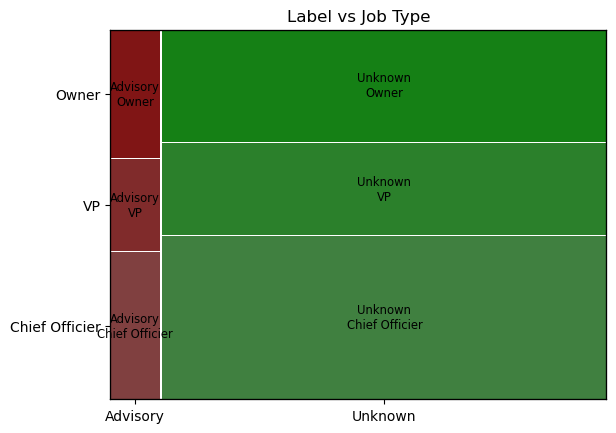

In [71]:
fig = mosaic(advClean, ['Label', 'Job Type'])
fig = plt.title("Label vs Job Type")
plt.show()

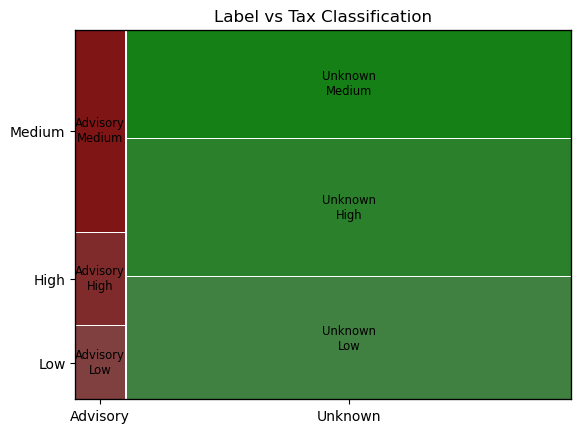

In [72]:
fig = mosaic(advClean, ['Label', 'Tax Classification'])
fig = plt.title("Label vs Tax Classification")
plt.show()

## 4 - Generating Features with the Second Dataset

The basic exploration and cleaning within the primary dataset is complete, so we will move onto the second dataset. The challenge suggests 3 features may be useful based on the client's suspicions

The features are: 

1) Most Recent Transaction Data
2) Most Frequent Type of Transaction
3) Total Number of Transactions
4) Total Amount of Transactions (Dollars)

My suspicion is that 2 and 3 are likely useful; however, 1 feels like it'd be more random than helpful. Regardless, we will develop, test, and analyze all 3, communicating our findings to the client. It's odd that there isn't a feature for total transaction amount or net transaction amount. My guess would be to start with total transaction amount because I would guess there is a connection between the dollar amounts transacted and tax complexity (as in, people doing more business likely have more complex tax situations). This may already be represented in Tax Classification, but it won't hurt to try. This feature is easy to make, so I will make it.

*Note: I would explore additional features as part of the challenge and to meet client needs. However, I am skipping this in the interest of time as this is a rush job to meet the timeline. I am of the belief that feature engineering and exploration, particularly interaction effects, are worth exploring to improve models.*

## Inspect the transaction data

We have no nulls and the types are as expected. Clearly the transaction date needs to be changed to a datetime via pd.to_datetime. This is standard as pandas does not automatically recognize dates. It is also a reason why I advocate for pkl files whenever possible.

### IDs
I checked to verify that all of the IDs are present, and they are not. Quick list comprehension shows that 3 Advisory and 17 Unknown observations are not included in this dataset. I'd imagine this is due to 1) client data quality, which is notoriously poor, or 2) there was no transaction activity for the given date range.

In practice, I would ask the client about 1). It's always possible someone made a small error that caused the observations to be omitted from the data. Due to time constraints, I am going to assume there was no activity and input logical labels such as "None" or 0 based on the context.

### Transaction Type

I didn't discover anything odd here. There are three categories and a "None" category will be added for the missing values.

#### IDs

In [73]:
allIDs = list(range(1,201))
transIDs = trans['ID'].unique()

In [74]:
missingIds = [x  for x  in allIDs if allIDs.index(x) not in transIDs] 

In [75]:
## Take a peak at the missing IDs and see if there is a clear trend or pattern
## None are present. i was hoping for something like all 20 missing IDs are missing
## Age and Income - I would drop those IDs, instead I have to be creative.
adv[adv['ID'].isin(missingIds)]

,ID,Label,Age,Income,Job Type,Tax Classification
0,1,Unknown,39.0,512000.0,Chief Officier,Low
10,11,Unknown,33.0,464000.0,Chief Officier,Medium
31,32,Advisory,52.0,581000.0,Chief Officier,Medium
56,57,Unknown,NaN,NaN,Owner,Low
74,75,Unknown,58.0,689000.0,Chief Officier,Low
76,77,Unknown,42.0,489000.0,Chief Officier,High
77,78,Unknown,43.0,480000.0,Chief Officier,Low
78,79,Unknown,NaN,NaN,Chief Officier,High
79,80,Unknown,42.0,480000.0,Chief Officier,High
80,81,Unknown,27.0,348000.0,Owner,Low


### Transaction Type

There are three types of transactions and no misspellings. No cleaning required here.

In [76]:
trans['Transaction_Type'].unique()

array(['Withdrawal', 'Payment', 'Deposit'], dtype=object)

In [77]:
trans['Transaction_Date'] = pd.to_datetime(trans['Transaction_Date'])

### Amount

We know none of these are null and we aren't using the individual transactions, rather the sum of transaction amounts. We will perform some light EDA on this feature after cleaning and prepping the data.

### Transaction Date

For this, I am going to identify the minimum and maximum transaction dates to understand the range, then use a date well in advance of the minimum as the NA filler for any missing values. Logically, this has to check out because they have not transacted in the range, and time is linear. Additionally, the client believes 

In [78]:
features = cleanPrepFeatures(trans)

In [79]:
features.head()

,ID,numTransactions,mostRecentAmount,mostRecentType,mostFrequentTrans,totalAmount
0,1,2.0,691.74,Withdrawal,Withdrawal,2205.74
1,2,4.0,776.38,Deposit,Deposit,5271.28
2,3,2.0,1094.84,Deposit,Multiple,1352.06
3,4,2.0,1032.42,Deposit,Multiple,2147.64
4,5,3.0,123.19,Deposit,Deposit,2721.64


## Pre-Modeling, Merge all Data

We now have a complete dataset that is ready for modeling.

In [80]:
## join it
modelingData = advClean.merge(features, how = 'left', on = 'ID')

## SKLearn does not like text in columns, drop_first to prevent overparameterizing a model
#X = pd.get_dummies(modelingData.drop(["ID", 'Label'], axis = 1))
X = modelingData.drop(["ID", 'Label'], axis = 1)



## get the y vector (s in the paper)
y = np.where(modelingData['Label'] == 'Advisory',
             1,
             0)

In [81]:
modelingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   ID                  200 non-null    int64   
 1   Label               200 non-null    object  
 2   Age                 200 non-null    float64 
 3   Income              200 non-null    float64 
 4   Job Type            200 non-null    category
 5   Tax Classification  200 non-null    category
 6   numTransactions     200 non-null    float64 
 7   mostRecentAmount    200 non-null    float64 
 8   mostRecentType      200 non-null    object  
 9   mostFrequentTrans   200 non-null    object  
 10  totalAmount         200 non-null    float64 
dtypes: category(2), float64(5), int64(1), object(3)
memory usage: 16.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------   

In [82]:
X.head()

,Age,Income,Job Type,Tax Classification,numTransactions,mostRecentAmount,mostRecentType,mostFrequentTrans,totalAmount
0,39.0,512000.0,Chief Officier,Low,2.0,691.74,Withdrawal,Withdrawal,2205.74
1,24.0,295000.0,VP,High,4.0,776.38,Deposit,Deposit,5271.28
2,36.0,445000.0,Chief Officier,High,2.0,1094.84,Deposit,Multiple,1352.06
3,50.0,565000.0,Chief Officier,Medium,2.0,1032.42,Deposit,Multiple,2147.64
4,19.0,327000.0,Owner,Low,3.0,123.19,Deposit,Deposit,2721.64


In [83]:
## Initiallize an encoder for each type - we can transform back easily if needed
leJT = LabelEncoder()
leTC = LabelEncoder()
leMRT = LabelEncoder()
leMFT = LabelEncoder()

X['Job Type'] = leJT.fit_transform(X['Job Type'])
X['Tax Classification'] = leTC.fit_transform(X['Tax Classification'])
X['mostRecentType'] = leTC.fit_transform(X['mostRecentType'])
X['mostFrequentTrans'] = leTC.fit_transform(X['mostFrequentTrans'])

In [84]:
X.head()

,Age,Income,Job Type,Tax Classification,numTransactions,mostRecentAmount,mostRecentType,mostFrequentTrans,totalAmount
0,39.0,512000.0,0,1,2.0,691.74,3,4,2205.74
1,24.0,295000.0,2,0,4.0,776.38,0,0,5271.28
2,36.0,445000.0,0,0,2.0,1094.84,0,1,1352.06
3,50.0,565000.0,0,2,2.0,1032.42,0,1,2147.64
4,19.0,327000.0,1,1,3.0,123.19,0,0,2721.64


### Fit a model

I chose a Random Forest because I don't have to perform variable selection and this is a rush job. Cutting out a step helps. In general, I would try mutliple different SKLearn estimators here to be thorough.

Step 1 is to get a model fit and make some predictions. We don't care about the predictions because this is not cross-validated, but I will check them. The next part will be some hyperparameter tuning, and then we will fit and recover the predictions.

In [85]:
#svc = SVC(C=10, kernel='rbf', gamma=0.4, probability=True)
rfClass = RandomForestClassifier(random_state=seedA)
EN = ElkanotoPuClassifier(estimator=rfClass, hold_out_ratio=0.2)

### Typically SKLearn can accept a dataframe for X, however, this is throwing an error
### It's probably the Elkan Noto implementation, I'm not going to crack this open right now
EN.fit(X.values, y)

ElkanotoPuClassifier(estimator=RandomForestClassifier(random_state=10),
                     hold_out_ratio=0.2)

In [86]:
yHat = EN.predict(X.values)

The model that without tuning thinks there are 65 potential clients in this dataset. Cool! We probably want to explore these.

The context of this problem is a bit different than standard ML.

In [87]:
np.sum(yHat)

49.0

In [88]:
modelingData['yHatEN'] = yHat

The model predicted 100% of the current candidates are potential candidates. That's very good, but we may want to play with the threshold to prevent bad predictions.

In [89]:
np.sum(modelingData['yHatEN'][modelingData['Label'] == 'Advisory'])

19.0

### Cross-validated grid search

Let's tune the random forest. I won't constrict the features because there are a ton of factors in there, and only including some factor levels feels odd. 

In [90]:
rfParams = {'n_estimators': [100,300,500], ## try a few arbitrary numbers of trees
          'max_depth': [2, 5, 10, None], ## set the maximum number of partitions
          'min_samples_split': [2, 10, 30], ## try constraining the num obs at the nodes
          'max_features': [None] ## there are 3 predictors, constraining the features is useless
         }

One of the fun things about using GridSearchCV here is that I have to build the estimators and pass them through. It will not accept the rf params. I'm going to write a for loop that builds classifiers and adds them to a list, which will go into a dictionary.

In [96]:
allModels = []

for est in rfParams['n_estimators']:
    for depth in rfParams['max_depth']:
        for feats in rfParams['min_samples_split']:
            rfClass = RandomForestClassifier(n_estimators = est,
                                             max_depth = depth,
                                             min_samples_split = feats)
            allModels.append(rfClass)
ENParams = {'estimator': allModels}

In [97]:
rfClass = RandomForestClassifier()
EN = ElkanotoPuClassifier(estimator = rfClass, hold_out_ratio=0.2)

grid = GridSearchCV(EN, ENParams, cv = 10, scoring='recall')
grid.fit(X.values,y)

/Users/John/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/John/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/John/anaconda3/lib/python3.10/site-packages/pulearn/elkanoto.py", line 72, in fit
    hold_out_predictions = self.estimator.predict_proba(X_p_hold_out)
  File "/Users/John/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 862, in predict_proba
    X = self

GridSearchCV(cv=10,
             estimator=ElkanotoPuClassifier(estimator=RandomForestClassifier(),
                                            hold_out_ratio=0.2),
             param_grid={'estimator': [RandomForestClassifier(max_depth=2),
                                       RandomForestClassifier(max_depth=2,
                                                              min_samples_split=10),
                                       RandomForestClassifier(max_depth=2,
                                                              min_samples_split=30),
                                       RandomForestClassifier(max_depth=5),
                                       RandomForestClassifier(max_depth=5...
                                       RandomForestClassifier(max_depth=2,
                                                              min_samples_split=10,
                                                              n_estimators=500),
                                       RandomForestClassifier(max_depth=2,
                                                              min_samples_split=30,
                                                              n_estimators=500),
                                       RandomForestClassifier(max_depth=5,
                                                              n_estimators=500),
                                       RandomForestClassifier(max_depth=5,
                                                              min_samples_split=10,
                                                              n_estimators=500),
                                       RandomForestClassifier(max_depth=5,
                                                              min_samples_split=30,
                                                              n_estimators=500), ...]},
             scoring='recall')

This is so bad that I suspect the F1 Score calculation in sklearn might not work properly for PU data, which would require me to code something custom.

In [94]:
grid.best_score_

0.85

In [95]:
grid.best_params_

{'estimator': RandomForestClassifier(max_depth=2, max_features=None, n_estimators=300)}

## Findings
The F1 score qualifies as abysmal.y suspicion is that the baked in methods for GridSearchCV don't work properly because of the PU data as opposed to the traditional case-control format for classification. Seeing an F1 of .25 after 95% correct labels above doesn't make sense to me. I probably need to do additional research to determine the best way to evaluate a PU model's performance.

### Next Steps I would take
I would go back to the drawing board and try an SVM here to see if that improved the performance. If the performance is still poor, I would draw up a custom hyperparameter tuning approach as that could indicate that my suspicions are correct. In this, I would make 10 CV folds, holding out exactly 2 Positives and 18 Unknowns. Train on the remaining 180 observations and test the remaining 20, paying close attention to the predicted classes for the Positive labels. If my model identified the positive labels well, then I would assume it is identify all Positive labels well. I would test this for the random forest and SVM approaches, as it's not too much more of a lift.

### Client Communication

I would tell the clients all of the work we did to clean and prep, as well as the research we performed to ensure we are applying the correct models. Then I would talk about all of the models we trained. The purpose of this would be to communicate that we worked hard, paid close attention to detail, and they are receiving value for their money. Then I would go over the model performance, finally delivering the labeled values to the best of our ability.

I would request feedback after this is applied. Did the model perform well? Is there something we could adjust to make this better? Did the end user understand the potential candidates we supplied?

## Final Submission

I'm going to make a final submission even if the modeling exercise is light by my standards. I'm going to use the basic RF classifier that correctly identified 80% of the positives, as the parameter tuning was unsuccessful.

In [ ]:
submission = modelingData[['ID','yHatEN']].rename(columns= {'yHatEN':'predicted_label'})

In [ ]:
submission.to_csv('submission.csv', index=False)